# FAQ 1: Log vs. Linear emulator?

We default to linear emulators for stars, and log emulators for telluric lines.  In principle stars could benefit from the log emulator too.  Here we show a workflow for using a log emulator on stellar spectra.

In [1]:
import torch
from blase.emulator import SparseLogEmulator
from gollum.phoenix import PHOENIXSpectrum
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

`blasé` is much faster if you happen to have an NVIDIA® GPU.  Most consumer laptops don't have this hardware, but `cpu` codes will still work (just slower)!

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

Let's do everything identically as the Step 1 tutorial.

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

In [4]:
stellar_spectrum = PHOENIXSpectrum(teff=4700, logg=4.5, 
                                   wl_lo=wl_lo, wl_hi=wl_hi, download=True)

In [5]:
stellar_spectrum = stellar_spectrum.divide_by_blackbody()
stellar_spectrum = stellar_spectrum.normalize()
continuum_fit = stellar_spectrum.fit_continuum(polyorder=5)
stellar_spectrum = stellar_spectrum.divide(continuum_fit, handle_meta="ff")

## Pass in the natural log of the stellar flux

This works fine because we should essentially never have a negative value: the models always have positive and non-zero flux.

In [6]:
ln_flux_native = np.log(stellar_spectrum.flux.value)

We then simply swap the `SparseLinearEmulator` for a `SparseLogEmulator`:

In [7]:
%%capture
stellar_emulator = SparseLogEmulator(stellar_spectrum.wavelength.value, 
                             ln_flux_native, 
                             wing_cut_pixels=6000, prominence=0.01, device=device)
stellar_emulator.to(device)

We will still spot-check a before-and-after:

In [8]:
with torch.no_grad():
    stellar_pre = stellar_emulator.forward().cpu().numpy()

In [9]:
stellar_emulator.optimize(epochs=300, LR=0.01)

Training Loss: 0.00008799: 100%|█████████████████████████████| 300/300 [00:05<00:00, 56.92it/s]


In [10]:
with torch.no_grad():
    stellar_post = stellar_emulator.forward().cpu().numpy()

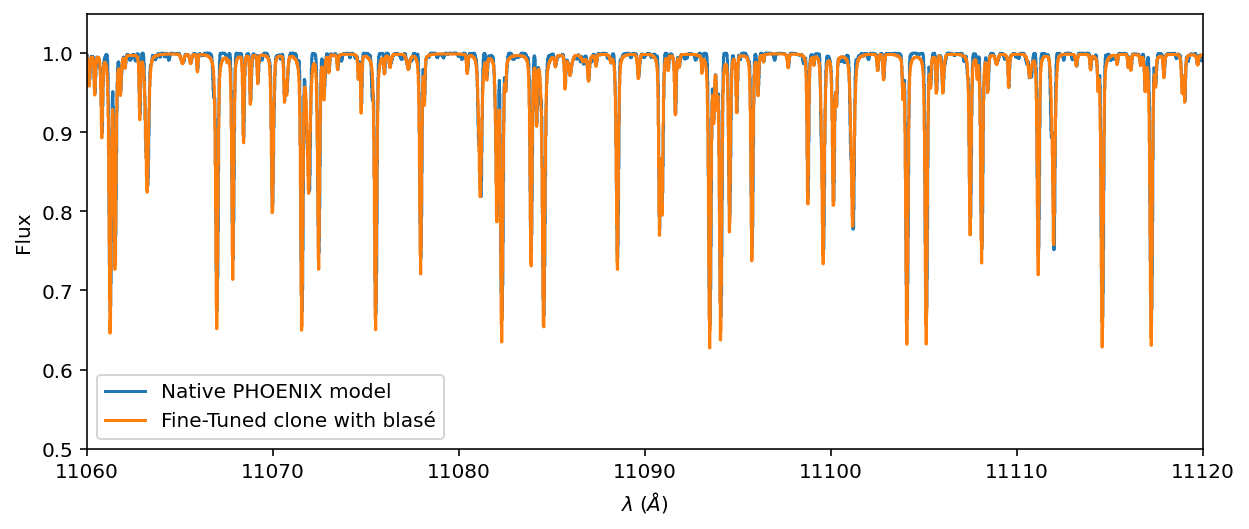

In [12]:
ax = stellar_spectrum.plot(ylo=0.5, yhi=1.05, label='Native PHOENIX model')
ax.step(stellar_spectrum.wavelength.value, stellar_post, label='Fine-Tuned clone with blasé')
ax.set_xlim(11_060, 11_120)
ax.legend();

We get almost identical performance as the linear emulator.  The log emulator is most necessary for saturated lines, which can occur in stellar spectra, but were not shown here.  So it's not a big surprise that we get about the same answer with either approach.